# Hands-on session I:  Mock catalogues, simulations vs observations - A practical yt-RAMSES tutorial
Tutor: S. Roca-Fàbrega

## Checking out the Roca-Fàbrega et al. (in prep.) GARROTXA-RAMSES simulation

In this notebook we will play a bit with a snapshot of a re-run of the cosmological Milky-Way-like galaxy simulations published by [Roca-Fàbrega et al. (2016)], now using the RAMSES code (http://adsabs.harvard.edu/abs/2016ApJ...824...94R). We will use the [yt]-multiplatform analysis tool(https://yt-project.org). 

A large variety of plots and analysis can be done by using yt. A detailed manual on how to use yt and on its capabilities can be found in https://yt-project.org/doc/cookbook/index.html .

### Getting prepared

In order for this tutorial to run, you need to have the conda environment "Athens2022" working on your PC.

To do that you should follow the instructions in:

https://github.com/Santiastro1/Athens_School_2022/blob/main/README.md



### Preparing working folders and data

Once you have your environment installed and working, check that you already have a folder called "Athens_School_2022" in your $HOME (you should if you followed the instructions to create the conda environment, see instructions above this paragraph), and a "HandsOnI" (you are suposed to be inside it if you are reading this notebook).

Now you need to get the data from Google Drive (it will be downloaded in your ~/Downloads folder): 

https://drive.google.com/drive/folders/1K2uZI-lobksJs3hcMOE6hm3oU8TCQkX0?usp=sharing


This is the GARROTXA_RAMSES snapshot at z~0.45 (output_00270). Once downloaded copy it to your ~/Athens_School_2022/HandsOnI folder. Caution!!! It may be downloaded in multiple compressed files, uncompress them and copy all of them to the GARROTXA_RAMSES folder. Once you get all of them, move the folder to the schools folder.

> mv ~/Downloads/GARROTXA_RAMSES ~/Athens_School_2022/HandsOnI/

For convenience, let's create also a folder where all plots will be stored (im_RAMSES), inside the ~/Athens_School_2022/HandsOnI/ folder:

> cd ~/Athens_School_2022/HandsOnI/

> mkdir im_RAMSES

Now, let' s check out the simulation. 

But, before loading the simulation we need to load yt module and also to define new fields and filters (e.g. metallicity as a new field for gas, filter young stars among all stars in the simulation):

In [2]:
import yt
import numpy as np
import matplotlib.pyplot as plt
from yt import YTArray

Now run the cell below to load the ART snapshot at z=0 (see information about snapshot properties, provided by yt when loading the snapshot):

In [3]:
@yt.particle_filter(requires=["conformal_birth_time"],
                    filtered_type='all')
def stars(pfilter, data):
    filter = data[(pfilter.filtered_type, "conformal_birth_time")] != 0
    return filter

@yt.particle_filter(requires=["conformal_birth_time"],
                    filtered_type='all')
def darkmatter(pfilter, data):
    filter = data[(pfilter.filtered_type, "conformal_birth_time")] == 0
    return filter

ds= yt.load('~/Athens_School_2022/HandsOnI/GARROTXA_RAMSES/output_00270/info_00270.txt', extra_particle_fields=  [('family', 'I'), ('info', 'I'),('particle_age','d'),('particle_metallicity','d')])
ds.add_particle_filter("stars")
ds.add_particle_filter("darkmatter")
#ds.add_particle_filter("young_stars")

yt : [INFO     ] 2019-12-29 12:15:04,411 Parameters: current_time              = 1.2629439549883048
yt : [INFO     ] 2019-12-29 12:15:04,412 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2019-12-29 12:15:04,413 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2019-12-29 12:15:04,413 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2019-12-29 12:15:04,414 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2019-12-29 12:15:04,415 Parameters: current_redshift          = 0.36706045919668306
yt : [INFO     ] 2019-12-29 12:15:04,415 Parameters: omega_lambda              = 0.699999988079071
yt : [INFO     ] 2019-12-29 12:15:04,416 Parameters: omega_matter              = 0.300000011920929
yt : [INFO     ] 2019-12-29 12:15:04,416 Parameters: hubble_constant           = 0.699999988079071
yt : [WARNING  ] 2019-12-29 12:15:04,422 Detected 1 extra gravity fields.


True

We add now new filters to the data source (ds):

In [4]:
def calc_mu_table_local(temperature):
                tt = np.array([1.0e+01, 1.0e+02, 1.0e+03, 1.0e+04, 1.3e+04, 2.1e+04, 3.4e+04, 6.3e+04, 1.0e+05, 1.0e+09])
                mt = np.array([1.18701555, 1.15484424, 1.09603514, 0.9981496, 0.96346395, 0.65175895, 0.6142901, 0.6056833, 0.5897776, 0.58822635])
                logttt= np.log(temperature)
                logmu = np.interp(logttt,np.log(tt),np.log(mt)) # linear interpolation in log-log space
                return np.exp(logmu)
temperature_values = []
mu_values = []
T_over_mu_values = []
current_temperature = 2.73*(ds.current_redshift+1)
final_temperature = 1e7
dlogT = 0.1
while current_temperature < final_temperature:
                temperature_values.append(current_temperature)
                current_mu = calc_mu_table_local(current_temperature)
                mu_values.append(current_mu)
                T_over_mu_values.append(current_temperature/current_mu)
                current_temperature = np.exp(np.log(current_temperature)+dlogT)
def convert_T_over_mu_to_T(T_over_mu):
                logT_over_mu = np.log(T_over_mu)
                logT = np.interp(logT_over_mu, np.log(T_over_mu_values), np.log(temperature_values)) # linear interpolation in log-log space
                return np.exp(logT)
               # The pressure field includes the artificial pressure support term, so one needs to be careful (compare with the exsiting frontends/ramses/fields.py)
def _temperature_3(field, data):
                        T_J = yt.YTArray(9000.0,'K')  # in K
                        n_H = yt.YTArray(10,'1/cm**3') # Should be density threshold for star formation
                        del_star=1000.
                        rhoc=yt.YTArray(1.88e-29,'g/cm**3') # Critical density
                        Omega_b=0.042
                        hubble=ds.hubble_constant
                        aexp=1/(ds.current_redshift+1)
                        gamma_0 = 1.333333
                        x_H = 0.76
                        mH = yt.YTArray(1.66e-24,'g')      # from pymses/utils/constants/__init__.py  (vs. in yt, mass_hydrogen_cgs = 1.007947*amu_cgs = 1.007947*1.660538921e-24 = 1.6737352e-24)
                        kB = yt.YTArray(1.3806504e-16,'cm**2*g/s**2/K') # from pymses/utils/constants/__init__.py  (vs. in yt, boltzmann_constant_cgs = 1.3806488e-16)
                        n_J = max(yt.YTArray(rhoc*del_star*Omega_b*(hubble)**2/aexp**3*x_H/mH,'1/cm**3'),n_H) #max value n_ISM vs. n_SF
                        T_over_mu = data["gas", "pressure"].in_units('g/s**2/cm')/(data["gas", "density"].in_units('g/cm**3')) * mH / kB - T_J * (data["gas", "density"].in_units('g/cm**3') * x_H / mH / n_J)**(gamma_0 - 1.0) # T/mu = T2 in Ramses
                        T_over_mu =T_over_mu
                        return YTArray(convert_T_over_mu_to_T(T_over_mu), 'K') # now T
ds.add_field(("gas", "temperature"), function=_temperature_3, force_override=True, units="K")          


/anaconda2/envs/Python3.7_env/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'


Now, we ask yt to show us all available fields (included in the snapshot)

In [6]:
ds.field_list

[('all', 'conformal_birth_time'),
 ('all', 'particle_birth_time'),
 ('all', 'particle_identity'),
 ('all', 'particle_mass'),
 ('all', 'particle_metallicity'),
 ('all', 'particle_position_x'),
 ('all', 'particle_position_y'),
 ('all', 'particle_position_z'),
 ('all', 'particle_refinement_level'),
 ('all', 'particle_velocity_x'),
 ('all', 'particle_velocity_y'),
 ('all', 'particle_velocity_z'),
 ('gravity', 'potential'),
 ('gravity', 'x-acceleration'),
 ('gravity', 'y-acceleration'),
 ('gravity', 'z-acceleration'),
 ('io', 'conformal_birth_time'),
 ('io', 'particle_birth_time'),
 ('io', 'particle_identity'),
 ('io', 'particle_mass'),
 ('io', 'particle_metallicity'),
 ('io', 'particle_position_x'),
 ('io', 'particle_position_y'),
 ('io', 'particle_position_z'),
 ('io', 'particle_refinement_level'),
 ('io', 'particle_velocity_x'),
 ('io', 'particle_velocity_y'),
 ('io', 'particle_velocity_z'),
 ('ramses', 'Density'),
 ('ramses', 'Metallicity'),
 ('ramses', 'Pressure'),
 ('ramses', 'var6'),

Yt creates derived fields from the main ones. We ask for information about the derived fields created by yt.

Note that the new fields we have just defined (e.g. particle_AlfaFe) also appear now in the derived_field_list:

In [7]:
ds.derived_field_list

[('all', 'age'),
 ('all', 'conformal_birth_time'),
 ('all', 'mesh_id'),
 ('all', 'particle_age'),
 ('all', 'particle_angular_momentum'),
 ('all', 'particle_angular_momentum_magnitude'),
 ('all', 'particle_angular_momentum_x'),
 ('all', 'particle_angular_momentum_y'),
 ('all', 'particle_angular_momentum_z'),
 ('all', 'particle_birth_time'),
 ('all', 'particle_cylindrical_velocity_theta'),
 ('all', 'particle_cylindrical_velocity_z'),
 ('all', 'particle_identity'),
 ('all', 'particle_index'),
 ('all', 'particle_mass'),
 ('all', 'particle_metallicity'),
 ('all', 'particle_ones'),
 ('all', 'particle_position'),
 ('all', 'particle_position_cylindrical_radius'),
 ('all', 'particle_position_cylindrical_theta'),
 ('all', 'particle_position_cylindrical_z'),
 ('all', 'particle_position_relative'),
 ('all', 'particle_position_relative_x'),
 ('all', 'particle_position_relative_y'),
 ('all', 'particle_position_relative_z'),
 ('all', 'particle_position_spherical_phi'),
 ('all', 'particle_position_sph

Now we load all data in the snapshot in the "ad" object.

In [5]:
ad=ds.all_data()

Now all fields can be explored easily by:

In [33]:
print(ad[('all','particle_mass')])

[7.53603434e+41 7.53603434e+41 7.53603434e+41 ... 7.41648624e+35
 3.80332628e+34 1.67346356e+36] g


Units can be changed from the "default code units", by using the "in_units" function:

In [34]:
print(ad[('all','particle_mass')].in_units('Msun')) #'kg, g, ...'

[3.78996893e+08 3.78996893e+08 3.78996893e+08 ... 3.72984665e+02
 1.91274187e+01 8.41606425e+02] Msun


In [35]:
print(ad[('stars','particle_birth_time')].in_units('Myr'))

[8352.64489598 8352.64629609 8337.49542048 ... 5878.36346812 7048.00549525
 2928.59104527] Myr


What is the unique identifier of a particle?

In [9]:
print(ad[('all','particle_index')])

[1.73240600e+07 1.73240610e+07 1.73240620e+07 ... 9.03313370e+07
 3.67524860e+07 3.06986821e+08] dimensionless


How many particles do we have?

In [10]:
print('n_all = %e: ndark = %e, nstar = %e\n'%(len(ad[('all','particle_mass')]),len(ad[('darkmatter','particle_mass')]),len(ad[('stars','particle_mass')])))

n_all = 5.807513e+08: ndark = 1.940565e+07, nstar = 5.613456e+08



How many gas cells do we have?

In [11]:
print('ngas = %e\n'%(len(ad[('gas','density')])))

ngas = 1.982590e+07



Where is the center of the main galaxy in the snapshot?

We first center the analysis box on the location with maximum stellar density. Later, iteratively, we recenter the box to the "all particles" center of mass.

speX (X being an integer) is a new spherical object centered on "center" and with a radius "rad", according to the sphere function: "ds.spere(center,rad)"

In [20]:
c1=ad.quantities.max_location(('deposit', 'stars_density'))
print(c1)
c2=[c1[1],c1[2],c1[3]]
print(c2)
spe0=ds.sphere(c2,(500,'kpc'))
c3=spe0.quantities.center_of_mass(use_gas=False,use_particles=True, particle_type = "stars")

spe1=ds.sphere(c3,(200,'kpc'))
c4=spe1.quantities.center_of_mass(use_gas=False,use_particles=True, particle_type = "stars")

spe2=ds.sphere(c4,(50,'kpc'))
c5=spe2.quantities.center_of_mass(use_gas=False,use_particles=True, particle_type = "stars")

spe3=ds.sphere(c5,(10,'kpc'))
c6=spe3.quantities.center_of_mass(use_gas=False,use_particles=True, particle_type = "stars")
print(c6.in_units("cm"))

spe4=ds.sphere(c6,(2,'kpc'))
c7=spe4.quantities.center_of_mass(use_gas=False,use_particles=True, particle_type = "stars")
print(c7.in_units("cm"))

spe5=ds.sphere(c7,(0.2,'kpc'))
center=spe5.quantities.center_of_mass(use_gas=False,use_particles=True, particle_type = "stars")
print(center.in_units("cm"))

[4.2626879179707386e-20 g/cm**3, 3.3175285698045365e+25 cm, 6.90129045099816e+24 cm, 5.3640956714916685e+25 cm]
[3.3175285698045365e+25 cm, 6.90129045099816e+24 cm, 5.3640956714916685e+25 cm]
[3.31736662e+25 6.91285841e+24 5.36478677e+25] cm
[3.31735974e+25 6.91334308e+24 5.36476231e+25] cm
[3.31735630e+25 6.91335466e+24 5.36476215e+25] cm


In [15]:
#center=yt.YTArray([3.31735630e+25,6.91335466e+24,5.36476215e+25],'cm')
spe3=ds.sphere(center,(10,'kpc'))

Following the yt cookbook we can make a large variety of "simple plots": https://yt-project.org/doc/cookbook/simple_plots.html

An example is a gas density slice plot:

yt : [INFO     ] 2019-12-29 12:16:25,130 xlim = 5679083627615069533110272.000000 8147625692384930243280896.000000
yt : [INFO     ] 2019-12-29 12:16:25,130 ylim = 52413350467615063795564544.000000 54881892532384928800702464.000000
yt : [INFO     ] 2019-12-29 12:16:25,132 xlim = 0.088061 0.126339
yt : [INFO     ] 2019-12-29 12:16:25,132 ylim = 0.812732 0.851009
yt : [INFO     ] 2019-12-29 12:16:25,133 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



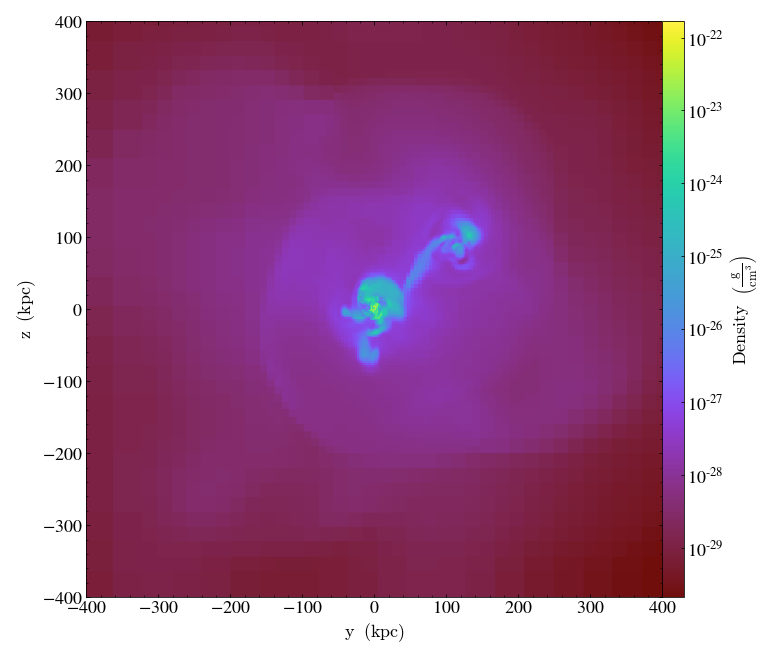

In [7]:
yt.SlicePlot(ds, 'x', "density", width = (800.0, 'kpc'),center=center)

We can save it in a file just by adding the ".save('filename.png')" command:

In [14]:
yt.SlicePlot(ds, 'x', "density", width = (800.0, 'kpc'),center=center).save('test_RAMSES.png')

yt : [INFO     ] 2019-12-29 12:06:38,768 xlim = 0.088061 0.126339
yt : [INFO     ] 2019-12-29 12:06:38,768 ylim = 0.812732 0.851009
yt : [INFO     ] 2019-12-29 12:06:38,769 xlim = 0.088061 0.126339
yt : [INFO     ] 2019-12-29 12:06:38,770 ylim = 0.812732 0.851009
yt : [INFO     ] 2019-12-29 12:06:38,771 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2019-12-29 12:06:39,203 Saving plot test_RAMSES.png


['test_RAMSES.png']

We can also produce Phase plots of all data in the "ad" object or in an sphere "spX" (e.g. Temperature-Density):

/anaconda2/envs/Python3.7_env/lib/python3.7/site-packages/yt/units/yt_array.py:1373: RuntimeWarning: invalid value encountered in log
  out_arr = func(np.asarray(inp), out=out, **kwargs)
/anaconda2/envs/Python3.7_env/lib/python3.7/site-packages/yt/units/yt_array.py:1394: RuntimeWarning: invalid value encountered in greater
  out=out, **kwargs)
/anaconda2/envs/Python3.7_env/lib/python3.7/site-packages/yt/units/yt_array.py:1394: RuntimeWarning: invalid value encountered in less
  out=out, **kwargs)



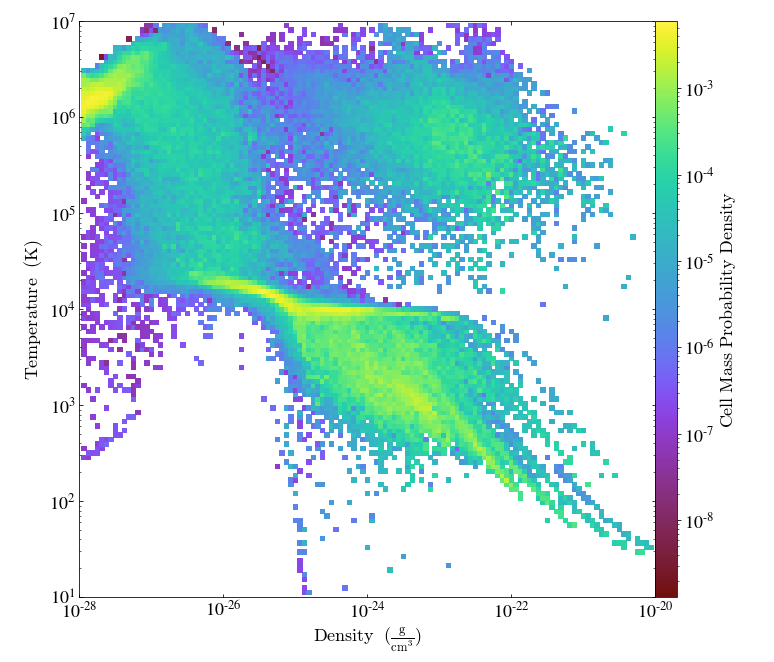

In [16]:
p=yt.PhasePlot(spe1, "density", "temperature", "cell_mass",
                    weight_field=None, fractional=True)
p.set_xlim(1e-28, 1e-20)
p.set_ylim(10, 1e7)

Simple radial profiles:


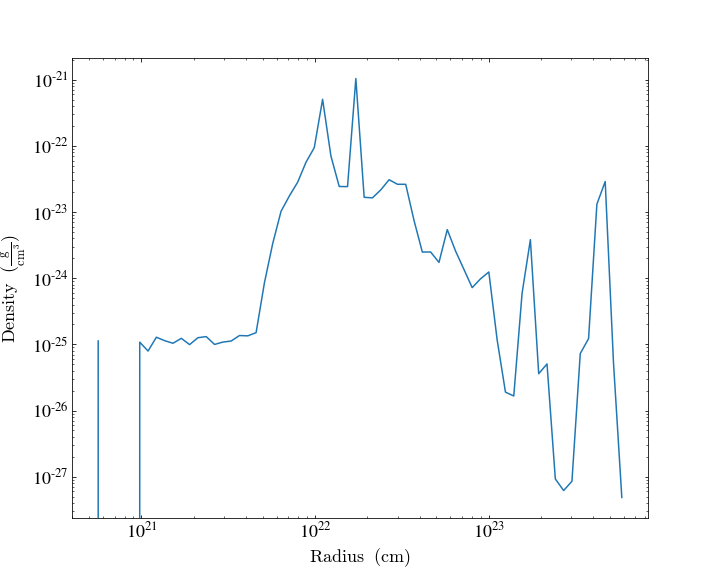

In [18]:
yt.ProfilePlot(spe1, "radius", "density",
                      weight_field="cell_mass")

We can also plot stars/DM properties by using the "Particle functions"

yt : [INFO     ] 2019-12-29 12:16:33,112 xlim = 32864995241903767611768832.000000 33482130758096229568086016.000000
yt : [INFO     ] 2019-12-29 12:16:33,112 ylim = 6604786901903767836295168.000000 7221922418096231940096000.000000
yt : [INFO     ] 2019-12-29 12:16:33,114 xlim = 32864995241903767611768832.000000 33482130758096229568086016.000000
yt : [INFO     ] 2019-12-29 12:16:33,114 ylim = 6604786901903767836295168.000000 7221922418096231940096000.000000
yt : [INFO     ] 2019-12-29 12:16:33,116 Splatting (('all', 'particle_mass')) onto a 800 by 800 mesh
/anaconda2/envs/Python3.7_env/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0



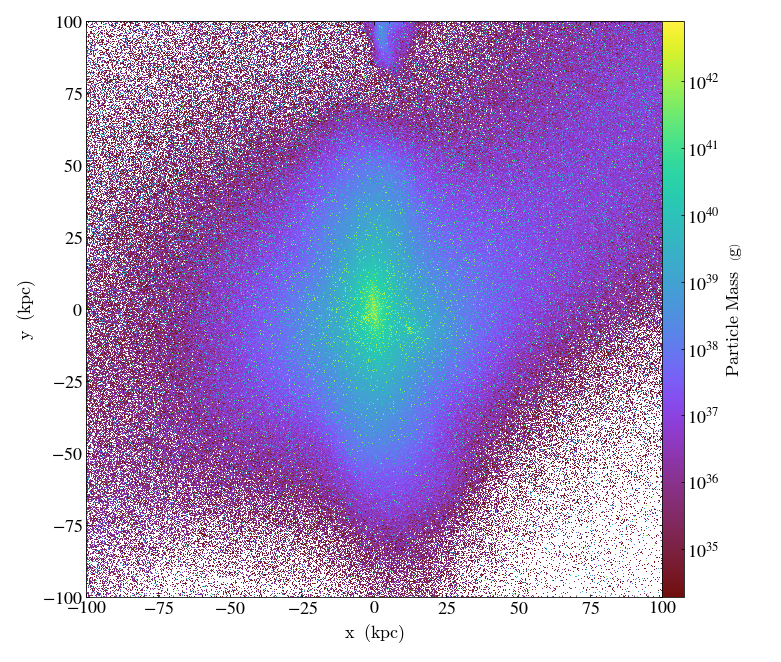

In [8]:
yt.ParticlePlot(ds, 'particle_position_x', 'particle_position_y', 'particle_mass', width=(200,'kpc'),center=center)

yt : [INFO     ] 2019-12-29 12:22:48,785 xlim = 32864995241903767611768832.000000 33482130758096229568086016.000000
yt : [INFO     ] 2019-12-29 12:22:48,787 ylim = 6604786901903767836295168.000000 7221922418096231940096000.000000
yt : [INFO     ] 2019-12-29 12:22:48,788 xlim = 32864995241903767611768832.000000 33482130758096229568086016.000000
yt : [INFO     ] 2019-12-29 12:22:48,789 ylim = 6604786901903767836295168.000000 7221922418096231940096000.000000
yt : [INFO     ] 2019-12-29 12:22:48,791 Splatting (('stars', 'particle_mass')) onto a 800 by 800 mesh
/anaconda2/envs/Python3.7_env/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0



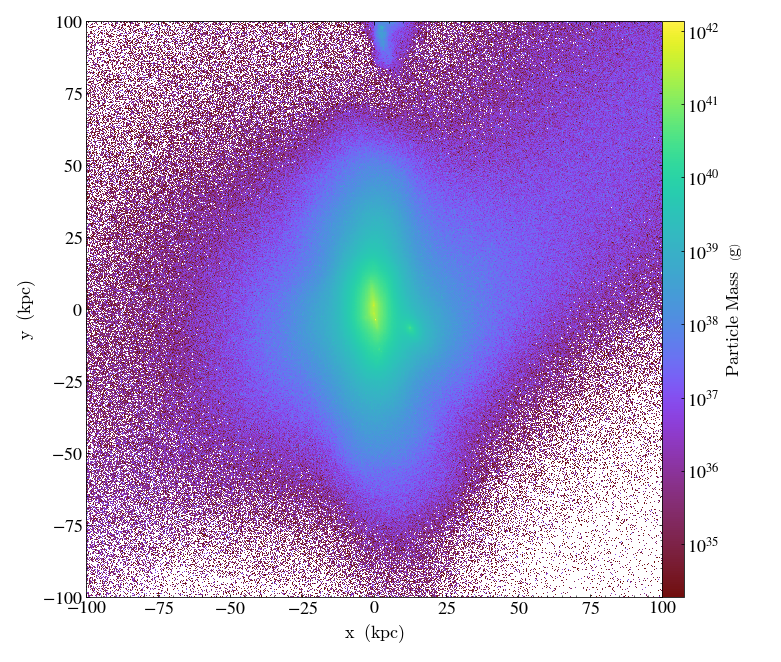

In [9]:
yt.ParticlePlot(ds, ('stars','particle_position_x'), ('stars','particle_position_y'), ('stars','particle_mass'), width=(200,'kpc'),center=center)

We can also view the filtered data (e.g. young stars):

yt : [INFO     ] 2019-12-29 12:35:47,899 xlim = 33019279120951880953364480.000000 33327846879048116226490368.000000
yt : [INFO     ] 2019-12-29 12:35:47,900 ylim = 6759070780951883325374464.000000 7067638539048116451016704.000000
yt : [INFO     ] 2019-12-29 12:35:47,901 xlim = 33019279120951880953364480.000000 33327846879048116226490368.000000
yt : [INFO     ] 2019-12-29 12:35:47,902 ylim = 6759070780951883325374464.000000 7067638539048116451016704.000000
yt : [INFO     ] 2019-12-29 12:35:47,904 Splatting (('young_stars', 'particle_mass')) onto a 800 by 800 mesh
/anaconda2/envs/Python3.7_env/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0



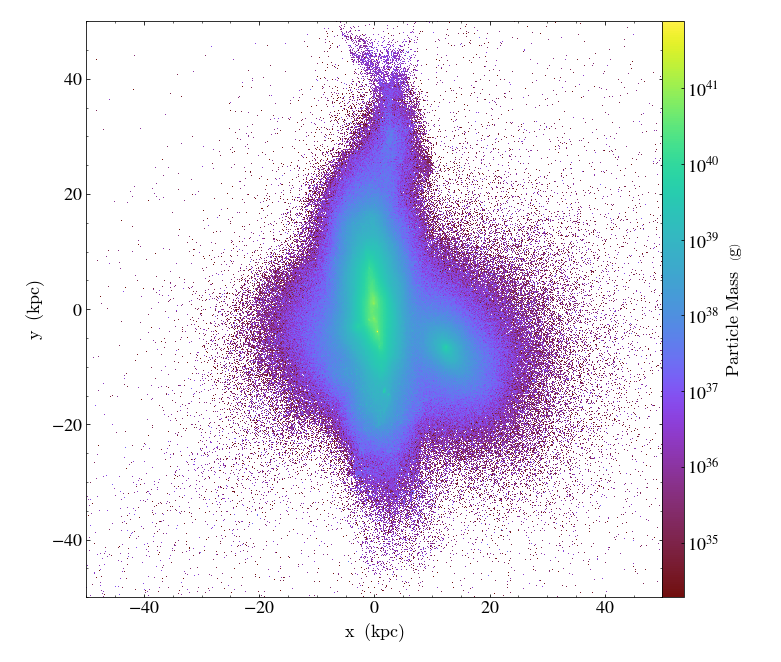

In [13]:
def young_star_filter(pfilter,data):
    filter=(data[(pfilter.filtered_type,"particle_birth_time")].in_units('Gyr') < 0.5)
    return filter
yt.add_particle_filter("young_stars",function=young_star_filter,filtered_type="stars",requires=["particle_birth_time"])
ds.add_particle_filter("young_stars")
yt.ParticlePlot(ds, ('young_stars','particle_position_x'), ('young_stars','particle_position_y'), ('young_stars','particle_mass'), width=(100,'kpc'),center=center)

We now compute the young stars angular momentum in spe3 (10kpc from center)

In [16]:
angular_momentum_young = spe3.quantities.angular_momentum_vector(use_gas=False,use_particles=True,particle_type='young_stars')
print (angular_momentum_young)

[-2.58015832e+29 -2.90007203e+28 -5.67846778e+27] cm**2/s


Face-on gas disk according to young stars angular momentum vector

yt : [INFO     ] 2019-12-29 13:24:21,567 xlim = -0.002392 0.002392
yt : [INFO     ] 2019-12-29 13:24:21,568 ylim = -0.002392 0.002392
yt : [INFO     ] 2019-12-29 13:24:21,569 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



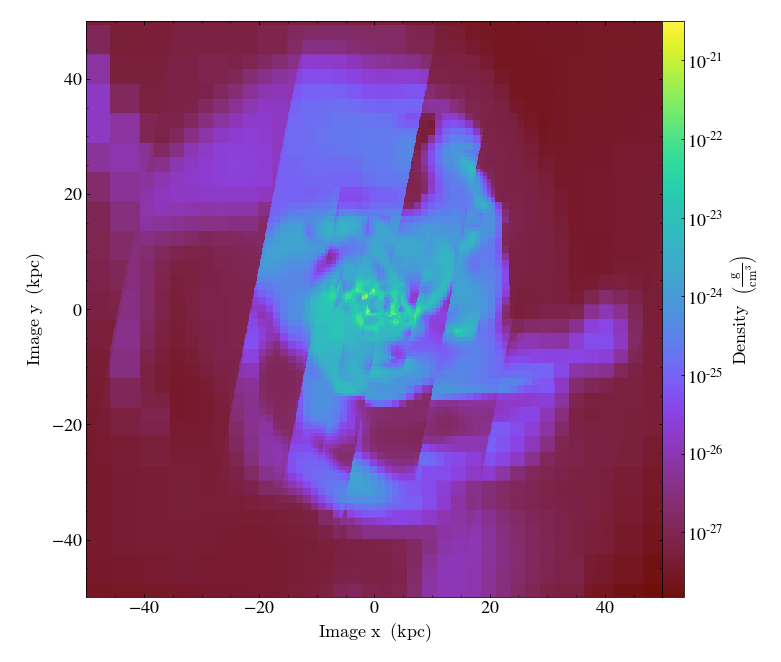

In [21]:
yt.OffAxisSlicePlot(ds, angular_momentum_young, "density", spe3.center, (100, "kpc"))

Many more, and more complex plots can be done by using yt functions (see yt cookbook for more examples).

Compute the rotation curve of this galaxy (total & separate for each component) by extracting radial mass profiles:

In [22]:
Mgas=yt.create_profile(spe1, "radius", "cell_mass", weight_field=None, accumulation=True, 
                    units={'radius': 'kpc', 'cell_mass': 'Msun'},extrema={'radius': (1e-2, 2e2)})
Mstar=yt.create_profile(spe1, ('stars','particle_spherical_position_radius'), 
                     ('stars',"particle_mass"), weight_field=None, accumulation=True,
                     units={('stars','particle_spherical_position_radius'): 'kpc', ('stars','particle_mass'): 'Msun'}
                     ,extrema={('stars','particle_spherical_position_radius'): (1e-2, 2e2)})
MDM=yt.create_profile(spe1, ('darkmatter','particle_spherical_position_radius'), 
                   ('darkmatter',"particle_mass"), weight_field=None, accumulation=True,
                    units={('darkmatter','particle_spherical_position_radius'): 'kpc', ('darkmatter','particle_mass'): 'Msun'}
                     ,extrema={('darkmatter','particle_spherical_position_radius'): (1e-2, 2e2)})
#print(Mgas.x.in_units('kpc'))
# print the profiled cell_mass field
#print(Mgas['cell_mass'].in_units('Msun'))

Now we compute the circular velocity curve (Newton's approximation)

In [23]:
from yt.units import G

#print ("Newton's constant: ", G)
Vcir_gas=np.sqrt(G*Mgas['cell_mass'].in_units('g')/Mgas.x.in_units('cm'))
Vcir_DM=np.sqrt(G*MDM[('darkmatter',"particle_mass")].in_units('g')/MDM.x.in_units('cm'))
Vcir_star=np.sqrt(G*Mstar[('stars',"particle_mass")].in_units('g')/Mstar.x.in_units('cm'))
Vcir_tot=np.sqrt(G*(Mgas['cell_mass'].in_units('g')+MDM[('darkmatter',"particle_mass")].in_units('g')+Mstar[('stars',"particle_mass")].in_units('g'))/Mgas.x.in_units('cm'))
#print(Vcir_tot.in_units('km/s'))
#print(Mgas.x.in_units('kpc'))

We plot the circular velocity curves using matplotlib

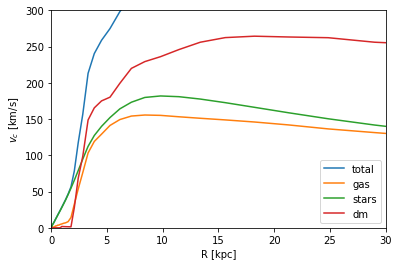

In [24]:

plt.plot(Mgas.x.in_units('kpc'),Vcir_tot.in_units('km/s'),label='total')
plt.plot(Mgas.x.in_units('kpc'),Vcir_gas.in_units('km/s'),label='gas')
plt.plot(Mstar.x.in_units('kpc'),Vcir_star.in_units('km/s'),label='stars')
plt.plot(MDM.x.in_units('kpc'),Vcir_DM.in_units('km/s'),label='dm')
plt.axis([0,30,0,300])

plt.xlabel('R [kpc]')
plt.ylabel(r'$v_c$ [km/s]')
plt.legend()
plt.show()